# Investigating Correlation Between Real Estate Characteristics, Including Walkability, and Home Price

<span style="font-size: 15px;">ECO225 Project 1 2024 By Samuel Ahn</span>
<span style="font-size: 15px;">1009008967, ahnsamue, sam.ahn@mail.utoronto.ca</span>

## Introduction:

Real estate has consistently been a focal point of economic research since the beginning of the discipline. This is due to the unique position that these assets hold within a consumer’s life. A home is both a financial asset, increasingly the most important financial asset to its owner, and a physical space by which they call home. This unique combination of traits leads to an obvious but all-important outcome: financial means determines location of residence, which determines mobility. Being able to traverse comfortably, safely, and easily has been proven to have a positive impact on living standards and happiness (Kim E. and Kim H. 2020, 593). This paper will aim to investigate the connections between real estate price and mobility. 
	
Given the importance of walkability on health, pollution, and community, several papers Investigating correlation between real estate value and walkability have been published in recent years (Pivo and Jeffery 2011, 185-219). Many of these papers rely on Ordinary Least Squares (OLS) regressions [(Kim E. and Kim H. 2020, 593), (Gou et. al 2017, 241-61)], but this paper will serve to dig deeper, employing regressions, geospatial maps, and machine learning to fully understand the connections between variables. Defining walkability is a difficult task, but luckily one that has already been done. There exists multiple large datasets mapping locational information to walkability metrics that this paper will be able to utilize in future iterations. The problem with quantifying walkability is that it ignores other forms of mobility, luckily, many datasets include parameters that aim to quantify those values as well. This paper lacks the ability to consider social aspects of property value (as in sentiment, design, or school quality), and thus will serve as an addition to the literature base that can be built upon with a more holistic review. 

This paper draws from real-estate data collected from Realtor.com, a real estate listing website, and contains over 1.4 million entries. This data will be supplemented with walkability data from the U.S. Census. These two datasets will allow analysis of correlation between price, walkability, and other real estate and mobility factors. In its current stage this paper prepares the data for a comprehensive analysis, and begins to analyze the correlations between walkability and price. Currently this paper uses price as the dependent Y-variable, as it represents a comparable standard regardless of personal preference. The chosen X-variables and their reasoning are listed below:

‘bed’: Describes the number of bedrooms found within the property. Chosen as installing more bedrooms may cost money, increasing the cost of the home

‘bath’: Describes the number of bathrooms found within the property. Similar reasoning to bedrooms, as installing more bathrooms may cost money, increasing the cost of the home.

‘acre_lot’: Describes the lot size of the property in acres. Chosen due to the assumption that land costs money, thus as the size of a lot increases its value will follow. 

‘house_size’: Describes the square footage of the home. Chosen due to the assumption that as the size of a home increases, the price of building and thus also selling will follow. 

‘sold_before’: A dummy variable representing if the home was sold previously. Perhaps newer homes will have higher values than older homes. 

As stated before, this paper will aim to predict the price of homes, but as shown in later, the ‘price’ variable is highly skewed, and its values are very large. For this reason, and more justified later within the paper, the Y variable for this data is a new variable ‘log_price’, representing the log of the ‘price’ variable. 



## Data Cleaning/Loading:

In [2]:
#import libraries   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydeck as pdk
import geopandas as gpd
from matplotlib.gridspec import GridSpec
from IPython.display import display, HTML
from shapely.geometry import Point


%matplotlib inline

/var/folders/nw/k9f62kj911z3ybmwjdmhbycw0000gn/T/ipykernel_744/2049719488.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
#read dataset and convert into a dataframe object
realtor= pd.read_csv("realtor-data.csv")
df=realtor.copy()
data_by_state = df.groupby('state')

The data has now been read into a dataframe object ‘df’, which will serve as the main dataframe for the remainder of the paper, and thus requires some additions. Here the dummy variable ‘sold_before’ is added, with value 0 representing a new home, and value 1 representing a home that has been previously owned. The variable ‘log_price’ is also added here, which will serve as the main Y-variable for this iteration of the paper. Included is a view of the first 5 rows of ‘df’, which confirms the two variables have been added successfully. This head also displays several variables not used during this iteration of the project. These variables include ‘city’,’zip_code’,and ‘status’. All three will be covered in further iterations of the project, and remain in the dataset for that reason. 

In addition, a grouped copy of ‘df’ has been created on the axis ‘state’. This dataframe will be used later in the paper. 


In [4]:
#Adding a dummy variable representing if a house has been sold before
df["sold_before"]=np.where(df.prev_sold_date.isnull(),0,1)
#creating new column in dataframe represinting log price values
df['price'] = df['price'].apply(lambda x: np.nan if x <= 0 else x)
df['log_price'] = np.log(df['price'])
df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price,sold_before,log_price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0,0,11.561716
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0,0,11.289782
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0,0,11.112448
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0,0,11.884489
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0,0,11.082143


Dataframe ‘df’ now has 12 columns (not including the index values), and 1401066 rows

## Summary Statistics Tables:

In [5]:
#printing summary statistics for numerical columns
def additional_stats(data_fr):
    additional_st ={
    'Mode': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].mode().iloc[0],
    'Variance': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].var(),
    'Skewness': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].skew(),
    'Kurtosis': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].kurtosis()
    }
    return(additional_st)


summary_stats = pd.concat([df[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].describe(), pd.DataFrame(additional_stats(df)).T])

display(HTML('<div style="font-size: 20px">Table 1: Summary Statistics of Data</div>'))
display(summary_stats)

,bed,bath,acre_lot,house_size,sold_before,price,log_price
count,1.184538e+06,1.206853e+06,1.043599e+06,9.509540e+05,1.401066e+06,1.400851e+06,1.400851e+06
mean,3.392347e+00,2.487426e+00,3.215013e+01,2.178643e+03,5.101637e-01,8.186654e+05,1.296942e+01
std,2.051858e+00,1.873599e+00,1.249983e+03,3.492618e+03,4.998969e-01,2.683162e+06,1.087928e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.000000e+00,2.000000e+00,1.200000e-01,1.170000e+03,0.000000e+00,2.350000e+05,1.236734e+01
50%,3.000000e+00,2.000000e+00,3.200000e-01,1.700000e+03,1.000000e+00,4.469000e+05,1.301009e+01
75%,4.000000e+00,3.000000e+00,1.340000e+00,2.500000e+03,1.000000e+00,7.950000e+05,1.358610e+01
max,1.230000e+02,1.980000e+02,1.000000e+05,1.450112e+06,1.000000e+00,8.750000e+08,2.058973e+01
Mode,3.000000e+00,2.000000e+00,6.000000e-02,1.200000e+03,1.000000e+00,5.990000e+05,1.330302e+01
Variance,4.210122e+00,3.510373e+00,1.562457e+06,1.219838e+07,2.498969e-01,7.199357e+12,1.183588e+00


Table 1 displays several interesting and important qualities of the data. Something immediately noticeable is the extreme skewness of every variable, but especially the price and house size variables. All variables are also extremely leptokurtic, signifying the possible presence of outliers. This point will be returned to before data-visualization begins, as the kurtosis is large enough to have a negative impact on readability of some figures and plots. In terms of values and in-context analysis, it is possible that these data include information about non-single family homes, as the max values of 123 bedrooms and 198 bathrooms hints towards multi-residential buildings. Another very interesting thing to notice is the extremely small median for acre_lot given its mean and standard deviation. This could be due to the large disparity in land access in urban vs. rural areas. It is rare to see an urban property with more than a small backyard, and common to see a rural home with acres of field or forest. The final important takeaway from these simple sample statistics is the amount of missing data. The variable with the most missing entries is house_size, followed closely by acre_lot. This may present itself as an issue in the future, and thus should be noted.

Due to these signs of extreme outliers, a new dataframe object will be created with said outliers removed. This dataframe will only be used for visualizations that are negatively impacted by the extreme outliers, and will be identified whenever it is used. The metric used to determine an extreme outlier within this dataset will be the interquartile range (IQR). The IQR method is used instead of z-scores due to the skewed distribution of the data. Because the goal of this action is to only remove truly extreme outliers, an 'extreme outlier' in this paper represents a datapoint with a value for any of the 6 variables presented in Table 1 (sans log_price) that is either below 4 IQRs from the 25th percentile, or above 4 IQRs from the 75th percentile. This prevents the removal of large amounts of data, and should have a minimal effect on the total number of entries.


In [6]:
#identifying which variables we would like to remove outliers for
columns_to_remove_outliers = {'bed','bath','acre_lot','price','house_size'}

#we create a version of our data without extreme outliers for plotting 
data = df.copy()

for column in columns_to_remove_outliers:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = (df[column] < (Q1 - 4 * IQR)) | (df[column] > (Q3 + 4 * IQR))
    data = data.loc[~outliers_iqr]

#printing summary statistics for new cropped data
summary_stats_no_outliers = pd.concat([data[['bed','bath','acre_lot','house_size','sold_before','price',\
                                             'log_price']].describe(), pd.DataFrame(additional_stats(data)).T])

display(HTML('<div style="font-size: 20px">Table 2: Summary Statistics With Extreme Outliers Removed</div>'))
display(summary_stats_no_outliers)


,bed,bath,acre_lot,house_size,sold_before,price,log_price
count,1.084162e+06,1.106097e+06,905578.000000,8.599080e+05,1.236847e+06,1.236634e+06,1.236634e+06
mean,3.250574e+00,2.288398e+00,0.736862,1.872933e+03,5.367527e-01,5.759970e+05,1.287875e+01
std,1.587158e+00,1.135867e+00,1.139696,1.050065e+03,4.986476e-01,5.176602e+05,9.629135e-01
min,1.000000e+00,1.000000e+00,0.000000,4.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000e+00,0.110000,1.134000e+03,0.000000e+00,2.350000e+05,1.236734e+01
50%,3.000000e+00,2.000000e+00,0.250000,1.620000e+03,1.000000e+00,4.250000e+05,1.295984e+01
75%,4.000000e+00,3.000000e+00,0.810000,2.341000e+03,1.000000e+00,7.290000e+05,1.349943e+01
max,1.200000e+01,7.000000e+00,6.220000,7.816000e+03,1.000000e+00,3.025000e+06,1.492242e+01
Mode,3.000000e+00,2.000000e+00,0.060000,1.200000e+03,1.000000e+00,5.990000e+05,1.330302e+01
Variance,2.519072e+00,1.290194e+00,1.298907,1.102636e+06,2.486494e-01,2.679721e+11,9.272024e-01


As shown in Table 2, removing the extreme outliers had a large effect on the skewness and kurtosis for all 5 variables. While all variables except for sold_before and log_price remain strongly right-skewed, the amount of skew has become far more reasonable for data visualizations. The data has also retained a very large number of entries, meaning that the 4 IQR range for classification was effective in keeping a vast majority of properties untouched. Interestingly, the removal of these outliers had small effects on most of the quantiles of all 5 variables, meaning that the outliers were indeed a small portion of the properties, and were only having a large impact on the standard deviations and means due to their extreme nature. 

The ultimate goal of this paper is to present data in a meaningful and understandable way, thus the improved clarity of certain figures was deemed worth this slight loss in data. 



## Plots, Histograms, Figures

The first important step that must be taken to understand the data is visualization of the key Y-variable, price. Here, both ‘price’ and ‘log_price’ are shown to display the differences, and justify the decision to use ‘log_price’ as the Y-variable.


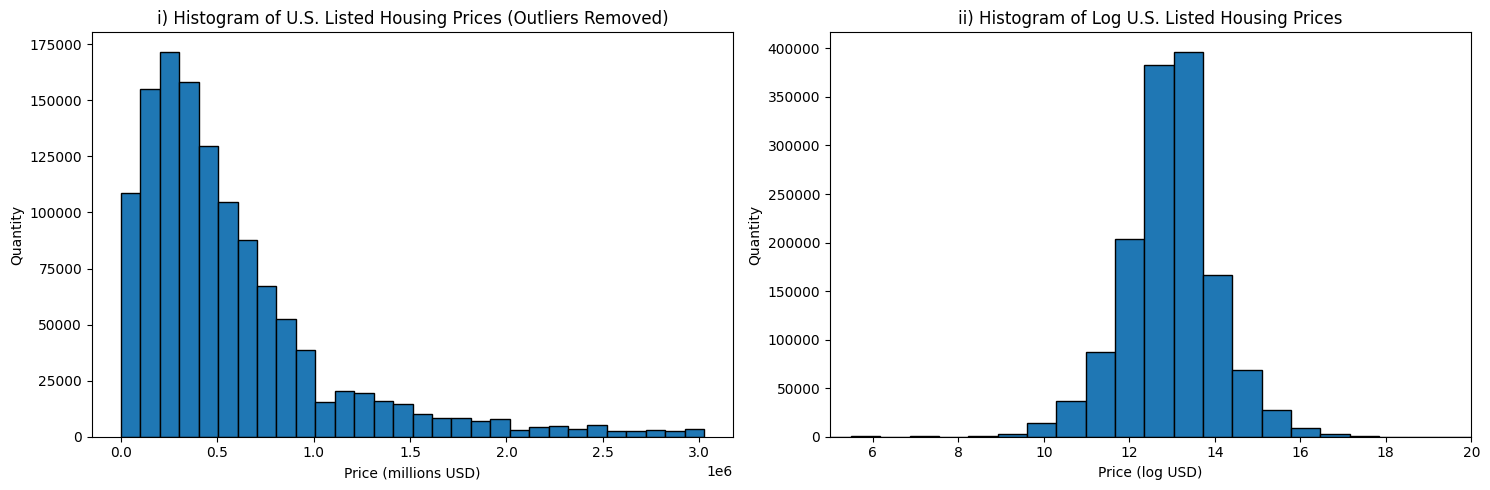

In [7]:
display(HTML('<div style="font-size: 20px">Figure 1: Price versus Log Price Distribution</div>'))

#Plotting data for price distribution
fig, fig_price = plt.subplots(1,2,figsize=(15,5))

fig_price[0].hist(data['price'],bins=30,edgecolor='black')
fig_price[0].set_title("i) Histogram of U.S. Listed Housing Prices (Outliers Removed)")
fig_price[0].set_ylabel("Quantity")
fig_price[0].set_xlabel("Price (millions USD)")

#Plotting data for log price distribution
fig_price[1].hist(df['log_price'],bins=30,edgecolor='black')
fig_price[1].set_title("ii) Histogram of Log U.S. Listed Housing Prices")
fig_price[1].set_ylabel("Quantity")
fig_price[1].set_xlabel("Price (log USD)")
fig_price[1].set_xlim(5,20)

plt.tight_layout()

Figure 1 is broken into two subfigures: 

F.1 i) depicts the distribution of variable ‘price’, clearly showing the positive skew identified within the summary statistics. This distribution is unimodal, with a clear peak at 250,000 USD. The distribution shows a clear change in slope at 1,000,000 USD, where the slope of the distribution decreases sharply. This is a point not seen in the ‘log_price’ data, and could become a point for grouping in the future. This distribution clearly shows the “bottom heavy” nature of the real estate market, where the majority of properties fall under the 1,000,000 USD mark. 

F.1 ii) presents as a unimodal, steep distribution with a peak of around 13. This is less intuitive than a value given by the ‘price’ distribution, but due to the symmetrical shape allows us to translate that the median of the data is around 440,000 USD, which matches the value we see in the summary statistics table. 

Both F.1 i) and F.1 ii) have their uses, but the distribution of only the Y-variable is insufficient to describe the entire dataset. 


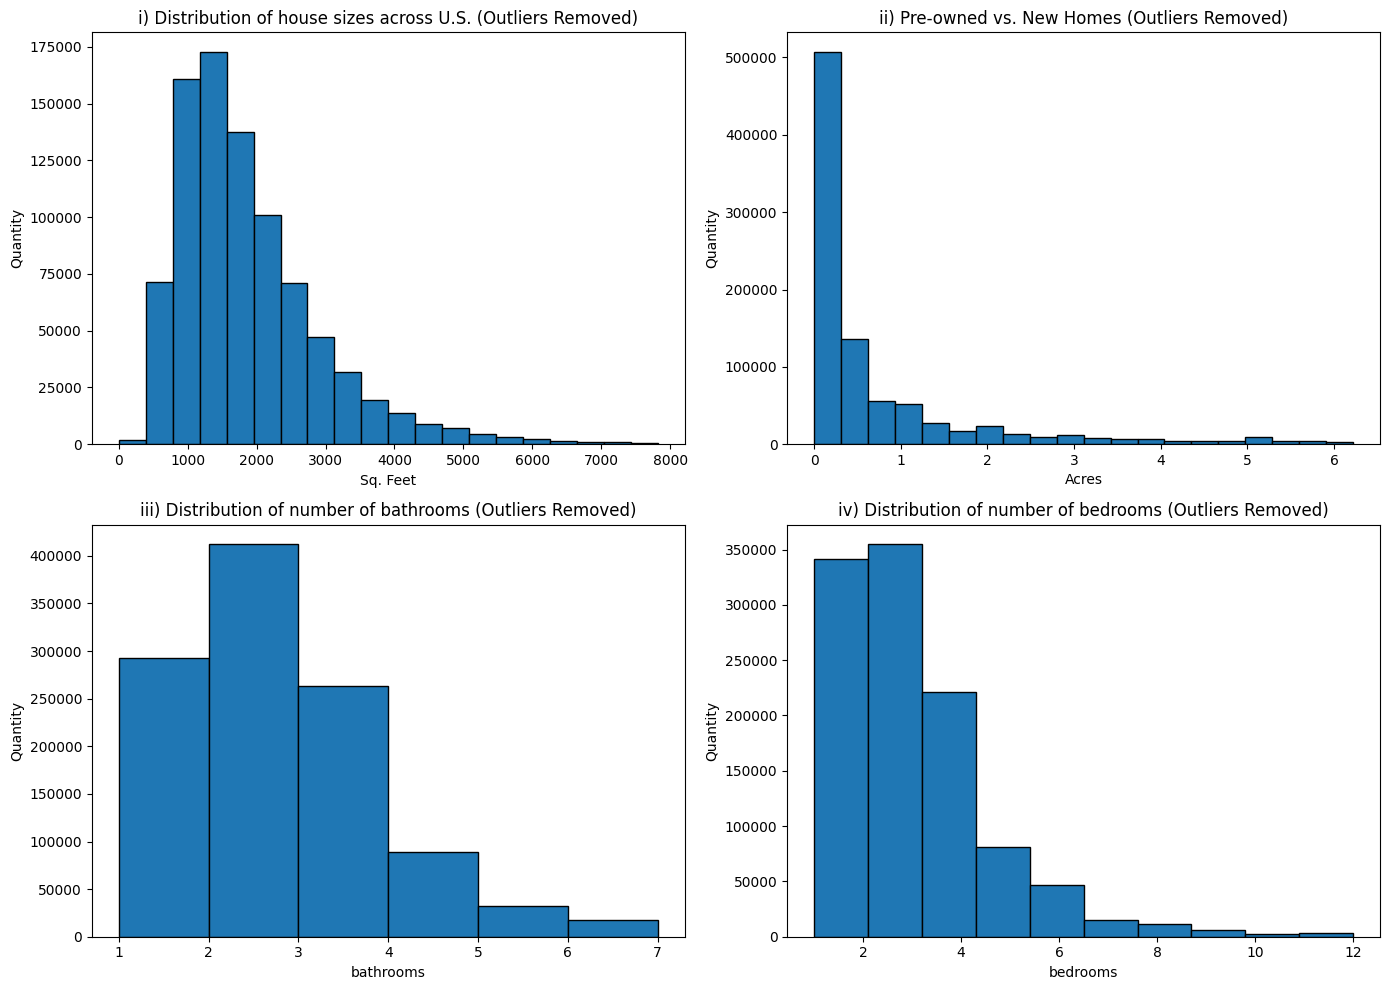

In [8]:
display(HTML('<div style="font-size: 20px">Figure 2: Distribution of X-variables</div>'))

def set_label(ax, title, x, y, a, b):
    ax[a,b].set_title(title)
    ax[a,b].set_xlabel(x)
    ax[a,b].set_ylabel(y)

fig, fig_1 = plt.subplots(2, 2, figsize=(14, 10))

fig_1[0,0].hist(data['house_size'], bins=20, edgecolor="black")
set_label(fig_1,'i) Distribution of house sizes across U.S. (Outliers Removed)','Sq. Feet','Quantity',0,0)

fig_1[0,1].hist(data['acre_lot'], bins=20, edgecolor='black')
set_label(fig_1,'ii) Pre-owned vs. New Homes (Outliers Removed)','Acres','Quantity',0,1)

fig_1[1,0].hist(data['bath'], bins=6, edgecolor="black")
set_label(fig_1,'iii) Distribution of number of bathrooms (Outliers Removed)','bathrooms','Quantity',1,0)

fig_1[1,1].hist(data['bed'], bins=10, edgecolor="black")
set_label(fig_1,'iv) Distribution of number of bedrooms (Outliers Removed)','bedrooms','Quantity',1,1)

plt.tight_layout()

Figure 2 again presents several subplots:

F.2 i) Shows the distribution of variable ‘house_size’. This distribution is similar to the house price distribution, hinting at a possible close correlation. Both unimodal and positively skewed, the most interesting finding being that very few homes are under 500 square feet. These homes typically represent studio apartments or sublet rooms, and are a lifeline for low-income consumers. The severe lack of these “micro-residences” may not be replicated in other countries, as the U.S. has traditionally strayed away from constructing properties of this nature. 

F.2 ii) Shows the distribution of the ‘acre_lot’ variable. This distribution shows visually the stark difference in property size between properties that was touched upon during analysis of the summary statistics. With the vast majority of homes holding less than 1 acre, the few properties holding large amounts of land, most of which are not pictured due to the removal of outliers, hold most of the land in the real estate market. 

F.2 iii) & F.2 iv) depict the distributions of the number of bathrooms and bedrooms respectively, and both share similar information. Both are unimodal and positively skewed, similar to all of the other distributions. The one difference between the two is the fact that homes tend to have less bathrooms than they do bedrooms. 

The fact that all four distributions look similar to each other and to the price distribution gives a hint at the possible correlation between each of them with the price variable. This is important for further research as having a strong correlation between these X-variables and the Y-variable will allow for easier isolation of the effects of walkability or other mobility data. The only X-variable not covered in these distributions is the ‘sold_before’ dummy variable, which will be better displayed in a pie chart. 


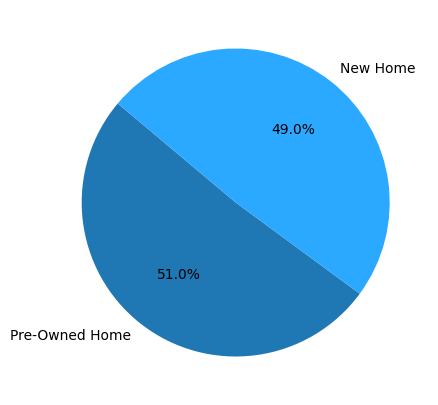

In [9]:
display(HTML('<div style="font-size: 20px">Figure 3: Distribution of Houses by Sold Before Status</div>'))
sold_counts = df['sold_before'].value_counts()

labels = ['Pre-Owned Home', 'New Home'] 

colors = ['#1f77b4','#2ba8ff']

fig, ax_status = plt.subplots(figsize=(5,5))
# Create pie chart
ax_status.pie(sold_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

plt.show()

Figure 3 clearly shows that while there are slightly more pre-owned homes than new homes, each represents essentially half of the data. This is good news for further research, as it means there is an abundance of data for both values of ‘sold_before’, allowing for conclusive results if they happen to present different trends when grouped separately. In combination with location and walkability data this would allow the ability to see if new developments were better or worse for walkability than their older counterparts, and where walkable developments are being constructed. 


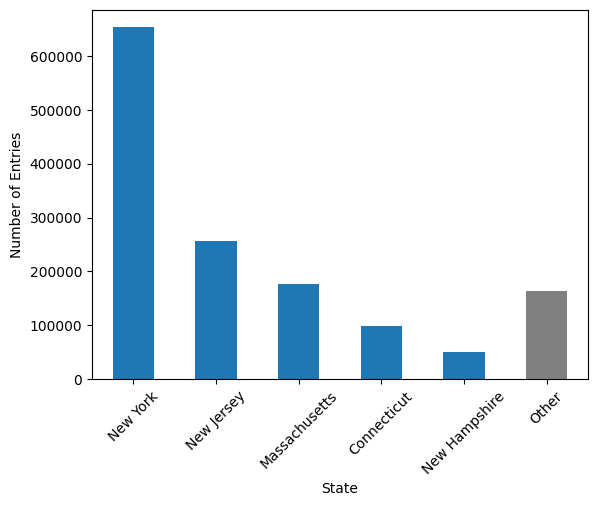

In [10]:
display(HTML('<div style="font-size: 20px">Figure 4: Number of Entries for Each State</div>'))
data_by_state_vals = df['state'].value_counts()

top_5_states = data_by_state_vals.head(5)
other_states_sum = data_by_state_vals[5:].sum()

colors_bar = ['#1f77b4','#1f77b4','#1f77b4','#1f77b4','#1f77b4','Grey']

# Using pd.concat instead of append
top_5_and_other = pd.concat([top_5_states, pd.Series([other_states_sum], index=['Other'])])

# Plot
top_5_and_other.plot(kind='bar',color=colors_bar)
plt.xlabel('State')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)  # Rotate state names for better readability
plt.show()

Figure 4 shows a bar plot representing the quantity of data for each state within ‘df’. As shown, New York represents a large portion of the data, followed by New Jersey and Massachusetts. This has major implications for conclusions drawn by the paper. These states all represent the North-Eastern United States, and while that alone does not present a problem, it limits this paper’s ability to draw conclusions about the entire U.S., as the northeast differs drastically from the west coast or the south. The northeast also represents some of the wealthier areas of the U.S. meaning that our data and findings may be skewed towards the higher end of the price bracket. Although, because the northeastern states share many qualities, there might be stronger conclusions when only applying to the northeast. 

After finally establishing the dataset, it is time for initial mapping of X-variables to the Y-variable. This initial stage will not be conducted on variable ‘sold_before’ as its nature as a dummy variable prevents transferrable conclusions in the same way as the other X-variables. That is not to say that it cannot predict the Y-variable, just that it will be covered in further research.


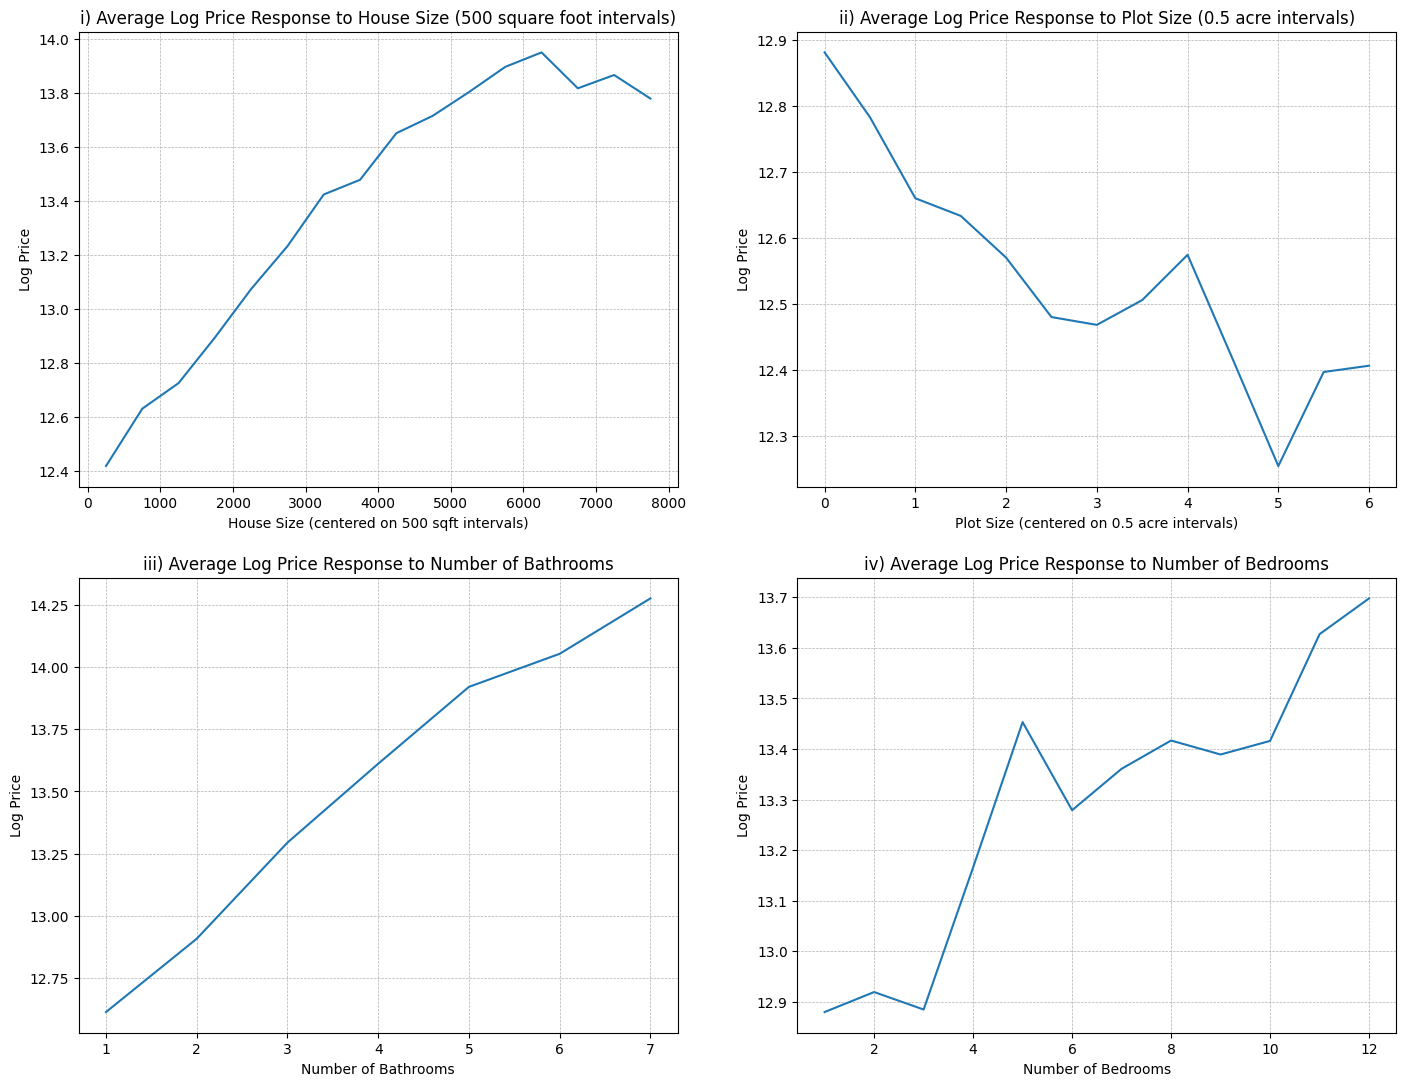

In [11]:
display(HTML('<div style="font-size: 20px">Figure 5: Price Responses to X-Variables</div>'))

data['house_size_interval'] = (data['house_size'] // 500) * 500 + 250
data['acre_interval'] = (data['acre_lot'] // 0.5) /2

# Initialize the figure
fig, ax = plt.subplots(2,2,figsize=(17, 13))

# Plot the average price for the entire dataset
overall_averages = data.groupby('house_size_interval')['log_price'].mean().reset_index()
ax[0,0].plot(overall_averages['house_size_interval'], overall_averages['log_price'], label='Overall')
set_label(ax,'i) Average Log Price Response to House Size (500 square foot intervals)',\
          'House Size (centered on 500 sqft intervals)','Log Price',0,0)
ax[0,0].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_acre = data.groupby('acre_interval')['log_price'].mean().reset_index()
ax[0,1].plot(overall_averages_acre['acre_interval'], overall_averages_acre['log_price'], label='Overall')
set_label(ax,'ii) Average Log Price Response to Plot Size (0.5 acre intervals)',\
          'Plot Size (centered on 0.5 acre intervals)','Log Price',0,1)
ax[0,1].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_bath = data.groupby('bath')['log_price'].mean().reset_index()
ax[1,0].plot(overall_averages_bath['bath'], overall_averages_bath['log_price'], label='Overall')
set_label(ax,'iii) Average Log Price Response to Number of Bathrooms','Number of Bathrooms','Log Price',1,0)
ax[1,0].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_bed = data.groupby('bed')['log_price'].mean().reset_index()
ax[1,1].plot(overall_averages_bed['bed'], overall_averages_bed['log_price'], label='Overall')
set_label(ax,'iv) Average Log Price Response to Number of Bedrooms','Number of Bedrooms','Log Price',1,1)
ax[1,1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

Figure 5 depicts 4 subplots, all of which show the average ‘log_price’ with respect to the X variable:

F.5 i) depicts the average ‘log_price’ response to each 500 square foot jump in ‘house_size’. This plot informs of the positive, weakly-linear relationship between house size and price. On average, the log price of a home increases rather consistently with an increase in home size. This conclusion is not surprising, as in the assumptions made when choosing house size as an X-variable, an increase in house size will cost money to build, increasing the sale price of the home. In terms of further research, this tells us that house size will be a strong predictor of home value.

F.5 ii) shows the average ‘log_price’ response to each 0.5 acre jump in ‘acre_lot’. This figure greatly contradicts the assumption made when acre_lot was chosen as an X-variable. As the plot size of a property increases, the value of the property actually decreases. This finding is so unintuitive that it is almost certainly linked to other factors. A possible explanation of this confusing finding can be drawn from the information from F.2 ii), that the vast majority of homes lie under the one acre mark. While the downward trend continues in this range, it makes sense that if the majority of properties lie within this group, there is a large chance that includes many high-value properties. This remains a highly interesting finding that will need to be both discussed and investigated further in future research. 

F.5 iii) depicts the average ‘log_price’ response to an increase in ‘bath’. This subfigure shows the closest to a linear correlation, with a slight decrease in slope after 5 bathrooms. Bathrooms are a necessity in every home, regardless of preference, and thus it reasons that a more expensive home will have more bathrooms. F.5 iii)’s findings almost perfectly match the assumption made when ‘bath’ was picked as an X-variable. In terms of future research, it may be interesting to view the importance of more bathrooms in an urban vs rural location, as perhaps more space-conscious urban residents value bathrooms differently than their rural counterparts. 

F.5 iv) represents the average ‘log_price’ response to an increase in ‘bed’. This subfigure has a very interesting shape compared to F.5 iii), contrary to the distributions which shared very similar qualities. F.5 iv) shows very sharp changes in average price for homes with different numbers of bedrooms, with the marginal value of an extra bedroom skyrocketing from 3 to 5. The strange changes in marginal log price presents an avenue for future research and discussion. Perhaps 5 bedrooms is the reasonable limit for urban residences?


# Project 2

## Merging With Another Dataset

In [13]:
display(HTML('<div style="font-size: 20px">Table 3: Merged Dataframe</div>'))

walkability = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv")
converter = pd.read_csv("ZIP_TRACT_122023.csv")

# Adjust city names for merging
df['city'] = df['city'].str.upper()
converter['USPS_ZIP_PREF_CITY'] = converter['USPS_ZIP_PREF_CITY'].str.upper()

# Rename columns in the converter to match those in df for a consistent merge
converter.rename(columns={'USPS_ZIP_PREF_CITY': 'city', 'ZIP': 'zip_code'}, inplace=True)

# Merge the DataFrames on 'city' and 'zip_code'
merged_df = pd.merge(df, converter[['city', 'zip_code', 'TRACT']], on=['city', 'zip_code'], how='left')
merged_df['TRACT'] = merged_df['TRACT'].astype('Int64').astype(str)

#Prepare the walkability DataFrame by creating a FIPS code
walkability['TRACT'] = walkability['STATEFP'].astype(str).str.zfill(2) + walkability['COUNTYFP'].astype(str).str.zfill(3) + walkability['TRACTCE'].astype(str).str.zfill(6)
walkability['TRACT'] = walkability['TRACT'].astype('Int64').astype(str)

#Merge the new df with the walkability score based on TRACT
final_df = pd.merge(merged_df, walkability[['TRACT', 'NatWalkInd', 'TotPop', 'CountHU']], on='TRACT', how='left')

conditions = [
    (final_df['TotPop'] > 5000) | (final_df['CountHU'] > 2000)
]
choices = ['Urban']

final_df['area_type'] = np.select(conditions, choices, default='Rural')
#Display the first few rows of the final DataFrame
final_df.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price,sold_before,log_price,TRACT,NatWalkInd,TotPop,CountHU,area_type
0,for_sale,3.0,2.0,0.12,ADJUNTAS,Puerto Rico,601.0,920.0,NaN,105000.0,0,11.561716,72001956800,2.666667,2380.0,969.0,Rural
1,for_sale,3.0,2.0,0.12,ADJUNTAS,Puerto Rico,601.0,920.0,NaN,105000.0,0,11.561716,72001956800,2.666667,2108.0,776.0,Rural
2,for_sale,3.0,2.0,0.12,ADJUNTAS,Puerto Rico,601.0,920.0,NaN,105000.0,0,11.561716,72113071700,6.666667,912.0,598.0,Rural
3,for_sale,3.0,2.0,0.12,ADJUNTAS,Puerto Rico,601.0,920.0,NaN,105000.0,0,11.561716,72113071700,5.666667,1021.0,609.0,Rural
4,for_sale,3.0,2.0,0.12,ADJUNTAS,Puerto Rico,601.0,920.0,NaN,105000.0,0,11.561716,72001956600,4.666667,1419.0,524.0,Rural


## The Message

## Maps and Interpretations

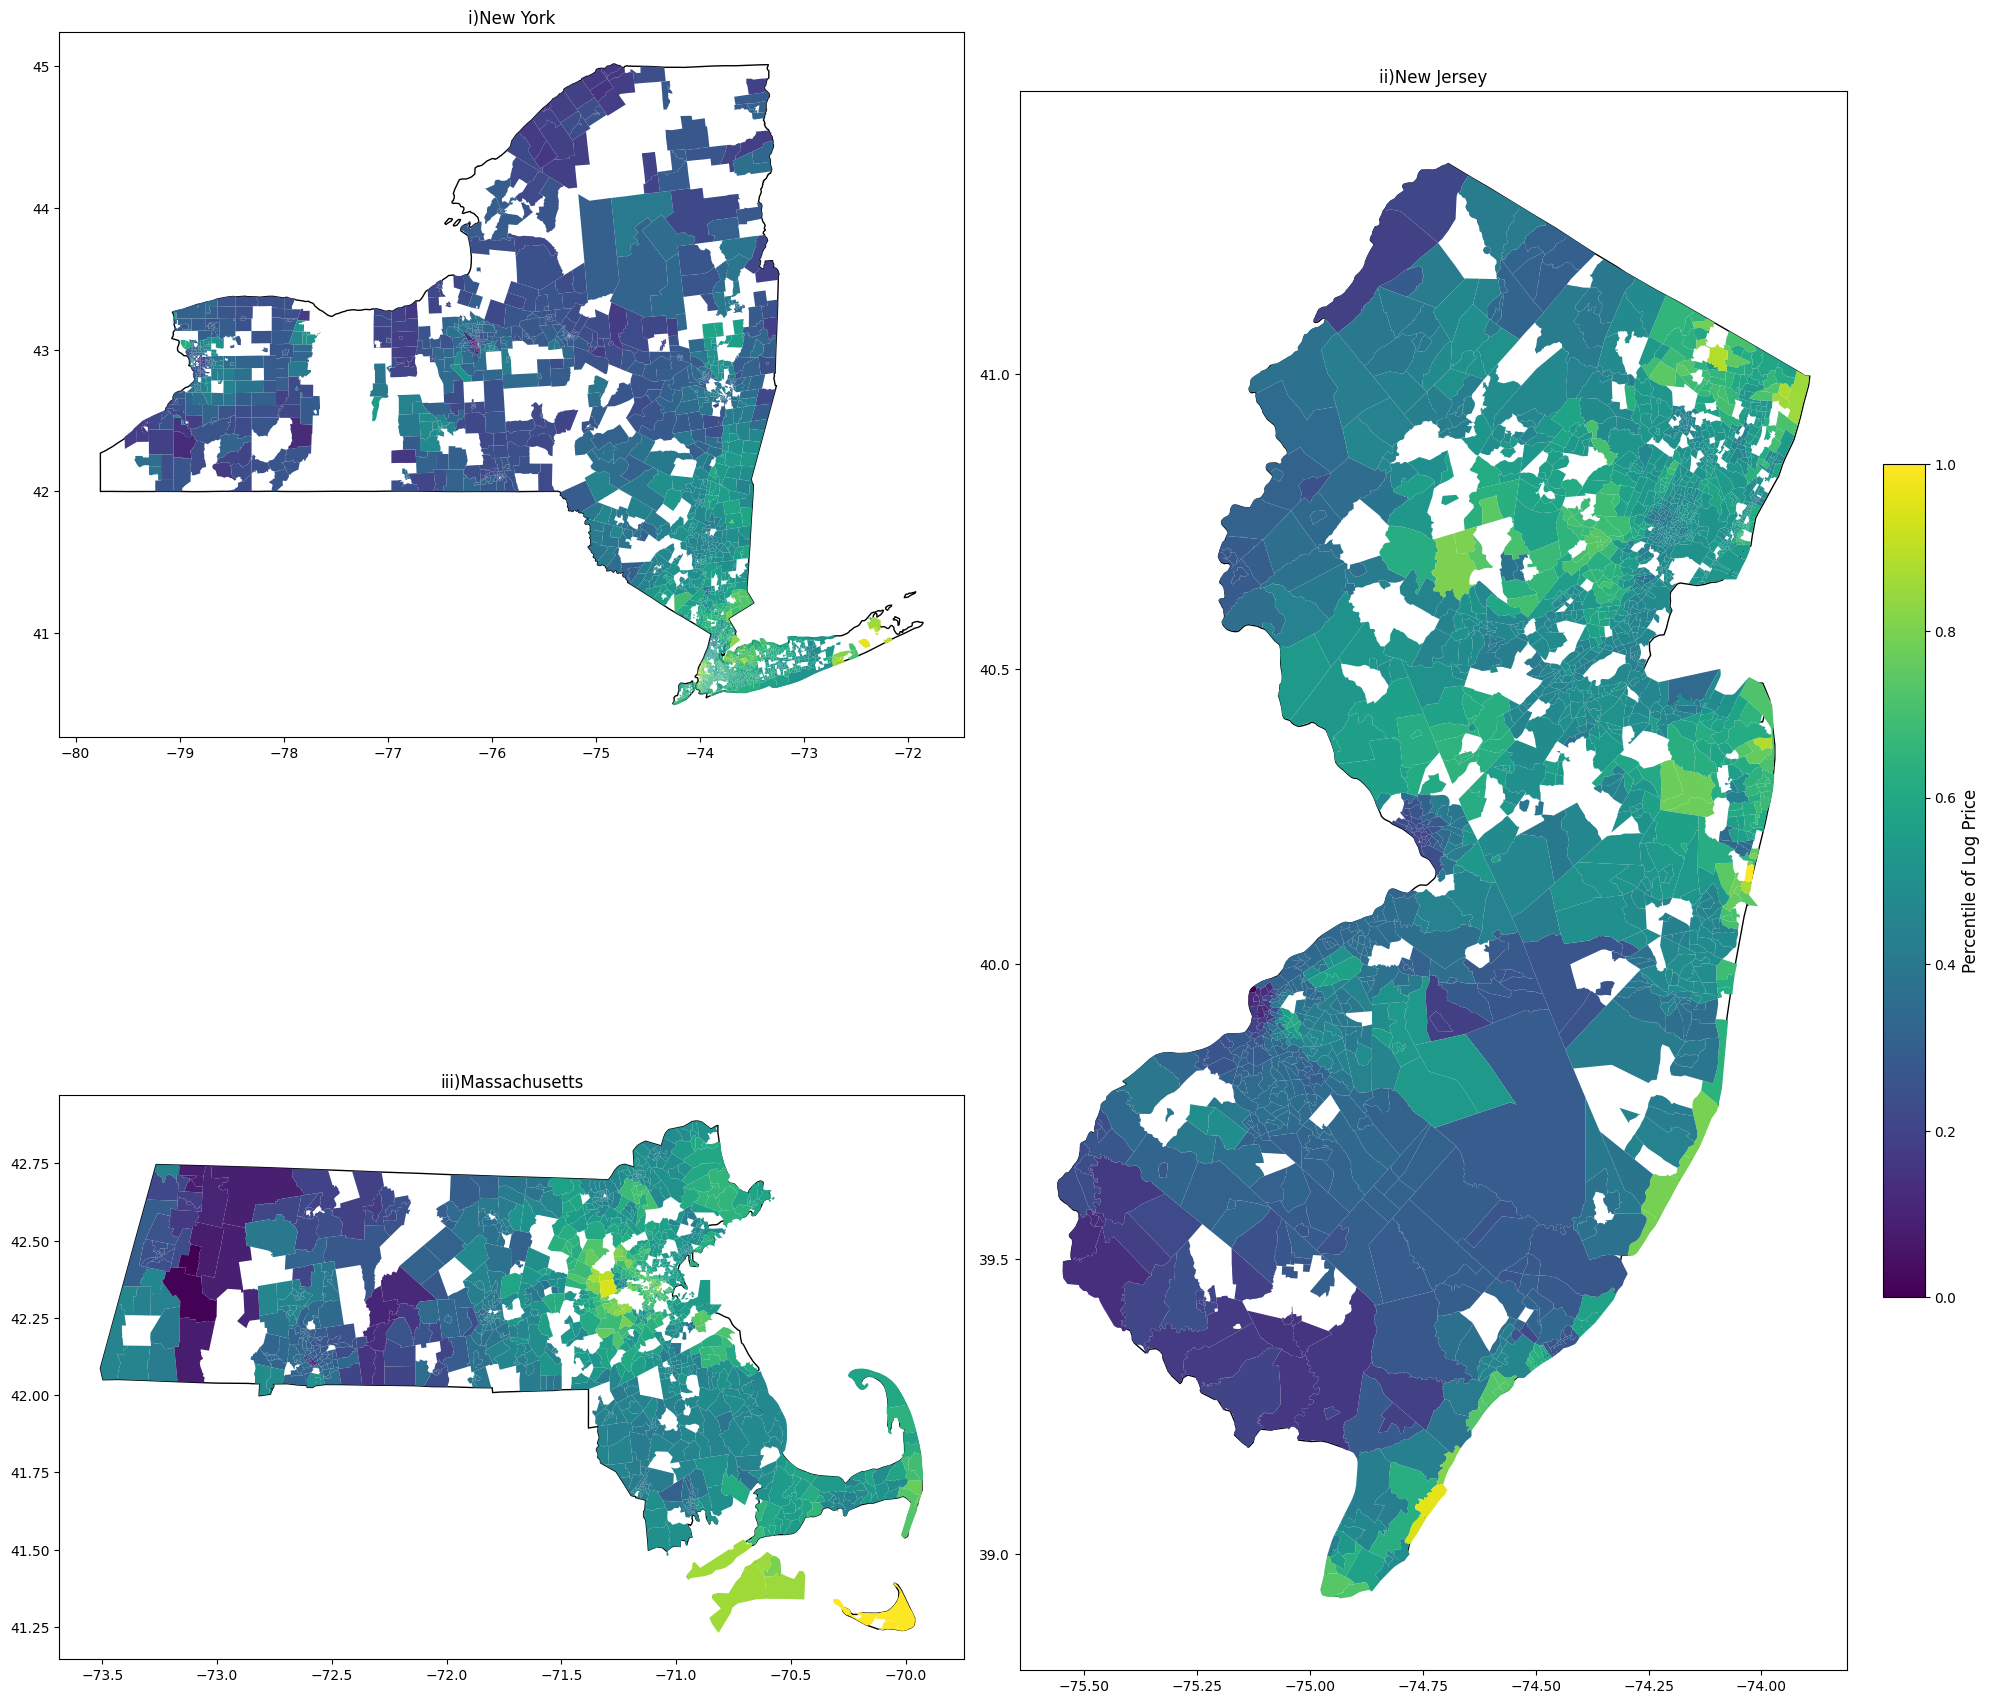

In [ ]:
base_url_geo = "http://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_"
state_fips_codes = {'NY': '36', 'NJ': '34', 'Mass': '25'}  # Connecticut removed

# Read state data
state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")

# Assuming final_df is defined somewhere in your code
# Example: final_df = pd.DataFrame(...)

merged_dfs = []
for state, fips in state_fips_codes.items():
    # Read and prepare tract data
    tract_df = gpd.read_file(f"{base_url_geo}{fips}_tract.zip")
    tract_df['TRACT'] = tract_df['STATEFP'].astype(str).str.zfill(2) + tract_df['COUNTYFP'].astype(str).str.zfill(3) + tract_df['TRACTCE'].astype(str).str.zfill(6)
    tract_df['TRACT'] = tract_df['TRACT'].astype('Int64').astype(str)
    
    # Merge with log_price data
    merged_df = pd.merge(tract_df, final_df.groupby('TRACT')['log_price'].mean().reset_index(), on='TRACT', how='left')
    merged_dfs.append(merged_df)

# Create figure and GridSpec layout
fig = plt.figure(figsize=(20, 20))
gs = GridSpec(2, 2, figure=fig)

# Assign subplots to GridSpec positions
ax1 = fig.add_subplot(gs[0, 0])  # New York
ax2 = fig.add_subplot(gs[:, 1])  # New Jersey, spanning two rows vertically
ax3 = fig.add_subplot(gs[1, 0])  # Massachusetts

# Define the axes and states together
axes_and_states = [(ax1, "New York", merged_dfs[0]), (ax2, "New Jersey", merged_dfs[1]), (ax3, "Massachusetts", merged_dfs[2])]
counter = 1

# Loop through each state, axis, and corresponding merged DataFrame
for ax, state, merged_df in axes_and_states:
    # Plot the state boundaries
    state_df[state_df["NAME"] == state].plot(ax=ax, color="white", edgecolor="black")
    
    # Plot the merged DataFrame
    if state == "New Jersey":
        merged_df.plot(ax=ax, column='log_price', legend=False, cmap='viridis',
                   vmin=merged_df['log_price'].min(), vmax=merged_df['log_price'].max())
        cbar = fig.colorbar(ax2.collections[0], ax=ax2, fraction=0.046, pad=0.04)
        cbar.set_label('Percentile of Log Price', fontsize=12)
    else:
        merged_df.plot(ax=ax, column='log_price', legend=False, cmap='viridis',
                   vmin=merged_df['log_price'].min(), vmax=merged_df['log_price'].max())

    
    # Set the title for each subplot to the name of the state
    ax.set_title("i"*counter + ") " + state)
    counter += 1
plt.tight_layout()
plt.show()

In [ ]:
view_state = pdk.ViewState(latitude = 43.2994, longitude = 74.2179, zoom = 9, max_zoom = 16, pitch = 60, bearing = 0)

walkability_tracts = pdk.Layer(
    "GeoJsonLayer",
    walkability,
    opacity=0.8,
    stroked=False,
    filled=True,
    extruded=True,
    wireframe=True,
    get_elevation="NatWalkInd",
    get_fill_color="[255, 255, properties.growth * 255]",
    get_line_color=[255, 255, 255]
)

r = pdk.Deck(
    walkability_tracts,
    initial_view_state= view_state,
)

#r.to_html("geojson_layer.html")

## Conclusion

In its current form, this paper serves as an introduction into the dataset, and lacks enough evidence to conclude much about any relationships other than surface level variation. The strange unimodal positively skewed data with high kurtosis that was present in almost every variable, the unexplained negative correlation of plot size and price, and most importantly the lack of walkability data represent immense potential for further research. Much could be gained by properly utilizing the untapped location data, which may require a transition into latitude and longitude coordinates via a function or external dataset. The addition of the U.S. walkability score dataset would also add several more potential X-variables, allowing for further analysis of the relationship between price and real-estate factors. 

In terms of results from this iteration of the project, the findings that house size, number of bedrooms and number of bedrooms fits with the findings of several other studies (Keskin 2008, 125-38). The unique negative correlation that price has with plot size is missing from the current papers analyzed, and thus remains a mystery of the data.  

The era of data analytics and machine learning means that a large dataset such as the one in this paper holds essentially infinite conclusions, many of which will hopefully be covered in further iterations of this paper. Along with machine learning, the introduction of regression and geospatial mapping will help shed light on many of the mysteries that current techniques are unable to answer. Overall, while a firm understanding of the dataset has been established, there remains vast potential for improvement. 


### References:

Guo, Yuntao, Srinivas Peeta, and Sekhar Somenahalli. 2017. The impact of walkable environment on single-family residential property values. Journal of Transport and Land Use 10 (1): 241-61.

Keskin, Berna. 2008. Hedonic analysis of price in the istanbul housing market. International Journal of Strategic Property Management 12 (2): 125-38, https://doi.org/10.3846/1648-715X.2008.12.125-138.

Kim, Eun Jung, and Hyunjung Kim. 2020. Neighborhood walkability and housing prices: A correlation study. Sustainability 12 (2): 593.

Pivo, Gary, and Jeffrey D. Fisher. 2011. The walkability premium in commercial real estate investments. Real Estate Economics 39 (2): 185-219.
